---
title: Observing Double Descent
author: Omar Armbruster
date: '2025-04-16'
image: "image.jpg"
description: "So you're telling me my model is too athletic?"
format: html
execute:
    message: false
    warning: false
---

# Abstract
After thorough investigation, scientists have concluded that repeatedly banging your head against a wall is not conducive to positive learning outcomes. Some studies have even gone on to conclude that such practices actually inhibit learning and development. However, some research has indicated that we may not be able to make such conclusions when it comes to teaching machines. In fact, such practices may allow us to achieve levels of accuracy previously thought to be impossible. It has been observed that as the number of features increases relative to the number of observations, the model will become more overfit and will thus have a higher testing loss. This testing loss will asymptotically approach the point where the number of features and observations are equivalent. Very counterintuitively, if we continue to make the loss worse by adding more features, we will ultimately reach a point where the loss begins to decrease again, plateauing at a testing loss lower than was previously observed. This phenomenon known as __double descent__ is an extremely desirable outcome for training reliable machine learning models and is the reason why deep learning models are able to achieve such high levels of accuracy with so many parameters. This blog post examines the double descent phenomenon by implementing and overfitting a linear regression model. We apply this method to a set of corrupted images and observe this change in the loss as we vary the number of features used to fit the model. 

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In order to test the effects of varying parameter sizes, we need to first define the `RandomFeatures` class, which selects $n$ random features and passes them through either a sigmoid activation function given by $$\sigma(x) = \frac{1}{1 + e^{-x}}$$ or a square activation function given by $$square(x) = x^2.$$ Using this approach, we can choose a random set of features (to avoid having our analysis be biased towards a specific singular feature) that are transformed with one of the two defined activation functions.

In [14]:
def sig(x): 
    return 1/(1+torch.exp(-x))

def square(x): 
    return x**2

class RandomFeatures:
    """
    Random sigmoidal feature map. This feature map must be "fit" before use, like this: 

    phi = RandomFeatures(n_features = 10)
    phi.fit(X_train)
    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    model.fit(X_train_phi, y_train)
    model.score(X_test_phi, y_test)

    It is important to fit the feature map once on the training set and zero times on the test set. 
    """

    def __init__(self, n_features, activation = sig):
        self.n_features = n_features
        self.u = None
        self.b = None
        self.activation = activation

    def fit(self, X):
        self.u = torch.randn((X.size()[1], self.n_features), dtype = torch.float64)
        self.b = torch.rand((self.n_features), dtype = torch.float64) 

    def transform(self, X):
        return self.activation(X @ self.u + self.b)

# Implementing Linear Regression
The standard formula for the optimal weight vector in least squares is given by $$\hat{\textbf{w}} = argmin_{\textbf{w}}||\textbf{Xw} - \textbf{y}||^2,$$ which has the closed-form solution $$\hat{\textbf{w}} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^T\textbf{y}$$ only when the number of data observations $n$ is larger than the number of features $p$. _This is because if $p > n$, the invertible matrix theorem will be violated_, making it impossible to find the inverse of $(\textbf{X}^T\textbf{X})$. When $p > n$, there are more columns of $\textbf{X}$ than rows, meaning that it is impossible for each of the columns to be linearly independent, which is a requirement by the invertible matrix theorem for a matrix to be invertible. 

As such, this solution will not hold for our experiments, meaning we need to alter our definition for the weight vector in our implementation of linear regression. We do this using the formula $$\hat{\textbf{w}} = \textbf{X}^+\textbf{y}$$ where $\textbf{X}^+$ is defined as the Moore-Penrose pseudoinverse of $\textbf{X}$. We accomplish this with the function `torch.linalg.pinv()` and use this to calculate our optimal weight vector in our `MyLinearRegression` implementation.

In [15]:
%load_ext autoreload
%autoreload 2
from linear import MyLinearRegression, OverParameterizedLinearRegressionOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple Data
We first examine the efficacy of our algorithm on a simple set of data, scattered randomly in a parabolic shape. Using our linear regression model, we expect to be able to fit these data quite accurately. We can first start by plotting the data to be fit, which is roughly parabolic as expected.

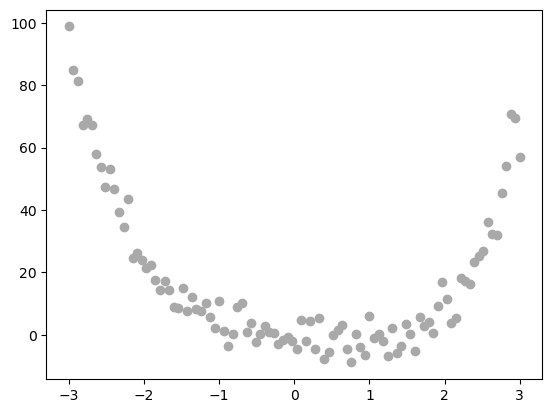

In [16]:
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype = torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

plt.scatter(X, y, color='darkgrey', label='Data')

We can then define our training dataset using the `RandomFeatures` class as discussed above. We choose $10$ features at random to feed to our model and transform them with the sigmoid activation function. We then define our linear regression model and our optimizer and fit the model on our feature data. Unlike previous algorithms, we do not need to solve the weights iteratively, as we can calculate the weight vector directly using the Moore-Penrose approach above.

In [17]:
phi = RandomFeatures(n_features = 10)
phi.fit(X)
X_train_features = phi.transform(X)

LR = MyLinearRegression()
opt = OverParameterizedLinearRegressionOptimizer(LR)
opt.fit(X_train_features, y)
# now LR.w has the optimal weight vector 

We can then define our predictions based on the calculated weights and plot them against the original data. The model appears to be a very good fit of the data. While the model cannot predict the values perfectly accurate, it appears that our predictions follow the same trend as the data and will make the correct predictions on average.

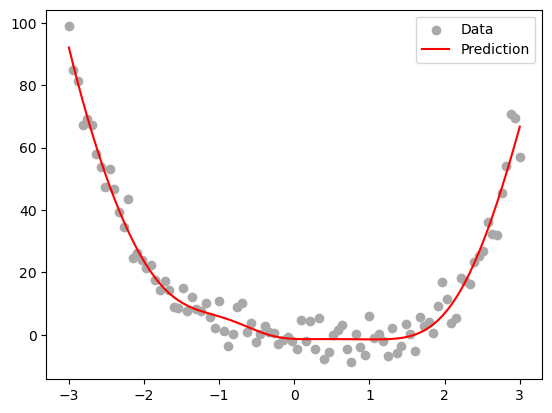

In [18]:
pred = LR.predict(X_train_features)
plt.scatter(X, y, color='darkgrey', label='Data')
plt.plot(X, pred, color = 'red', label = 'Prediction')
plt.legend()

# Corrupted Data and Overfitting
Now that we have confirmed our model is able to effectively fit a given dataset, we can examine the model's performance on more difficult problems. For this experiment, we will examine corrupted images where sections of the image have been removed. The goal of our model will be to fill in this missing sections as accurately as possible. The original, uncorrupted image can be seen below.

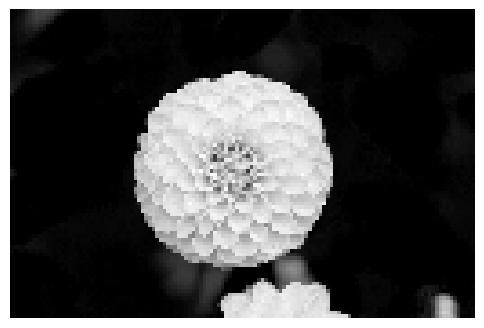

In [19]:
from sklearn.datasets import load_sample_images
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower, cmap = 'gray_r')
off = ax.axis("off")

We then define the corruption function, which will allow us to randomly remove sections of the image for our model to predict.

In [20]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

An example of the corrupted image can be seen below. Each gray square represents a missing section of the data for our linear regression model to predict. 

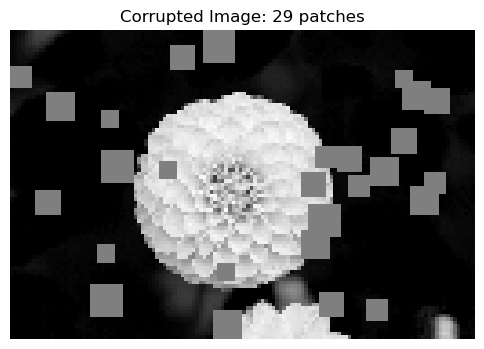

In [21]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1, cmap = 'gray_r')
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

Using our method for corrupting images, we can create training and testing datasets. We specify $n\_samples = 200$, meaning each of our datasets will have $100$ images in them. We then apply our `corrupted_image()` function to $200$ versions of our image and split them randomly into training and testing data.

In [22]:
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64)
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Now that we have our training and testing datasets, we can examine the performance of our linear regression model as the number of features varies. We fit and evaluate the model for $0-400$ features and store the training and testing losses, which will allow us to visualize how the efficacy of the model changes as the number of features increases. Unlike our previous experiment, we use the square activation function, which we have found through trial-and-error to be more effective in demonstrating double descent. 

In [23]:
max_feat = 401
mse_train = []
mse_test = []
for i in range(max_feat):
    phi = RandomFeatures(n_features = i, activation = square)
    phi.fit(X_train)
    X_train_features = phi.transform(X_train)
    X_test_features = phi.transform(X_test)
    LR = MyLinearRegression()
    opt = OverParameterizedLinearRegressionOptimizer(LR)
    opt.fit(X_train_features, y_train)
    tr_loss = LR.loss(X_train_features, y_train)
    te_loss = LR.loss(X_test_features, y_test)
    mse_train.append(tr_loss)
    mse_test.append(te_loss)


We plot the training loss (left) and the testing loss (right) as a function of the number of features used. In the training loss plot, we observe that as the number of features increases the training loss decreases. This is to be expected, as a greater number of features means more weights are used, allowing for more degrees of freedom in our fitting function. However, this also means that the model is becoming more overfit, as the greater degrees of freedom will allow the function to fit to smaller trends in the data that exist because of noise and will not be present in the testing set. Interestingly enough, the loss drops significantly once we approach $p = 100$ features, which is where the number of features is equal to the number of observations. While we would expect the loss to continue to decrease, this large jump in the loss is unexpected and indicates some change in the behavior of the model fit.

Our suspicions are confirmed when we observe the testing loss. As the number of features increases to $p = 100$, the testing loss increases, which we would expect because a more overfit model will not generalize as well to unique testing data. However, as we increase the number of features past $p = 100$, the loss counterintiuitively begins to decrease, reaching values lower than we observed prior to $p = 100$. This illustrates the double descent that we have been looking for. When we add enough features, the model becomes so overfit that it is no longer overfit and is actually more accurate than it was originally.

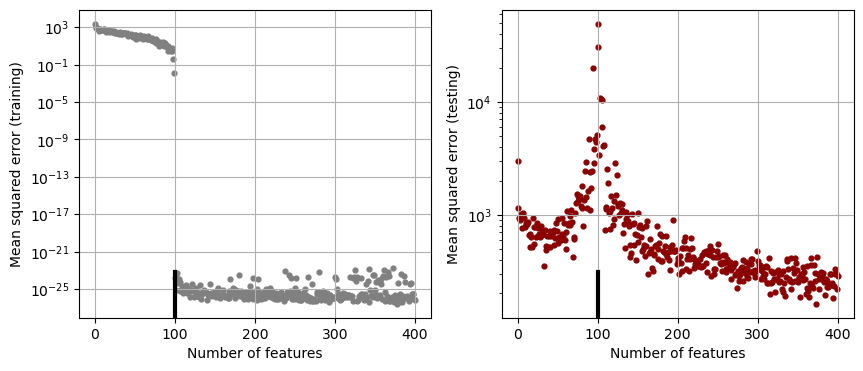

In [24]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
feat = np.linspace(0,max_feat - 1, max_feat)
ax[0].scatter(feat, mse_train, color = 'gray', s = 12)
ax[1].scatter(feat, mse_test, color = 'darkred', s = 12)
labs = ['training', 'testing']
for i in range(len(ax)):
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Number of features')
    ax[i].set_ylabel('Mean squared error ({})'.format(labs[i]))
    ax[i].grid(True)
    ax[i].axvline(100, color = 'black', ymax = 0.15, lw = 3)


We calculate the feature at which the minimum testing loss occurs using the code below. We find that the lowest testing loss is achieved when we use $373$ features, inidicating that the most efficient model is actually achieved when the number of features exceeds the number of observations rather than when we keep the number of features small as was originally expected.

In [25]:
feat[np.where(np.array(mse_test) == np.array(mse_test).min())][0]

373.0

# Conclusion
Through our experiments with our implemented linear regression model, we are able to design a set of experiements to observe double descent in action. By creating a linear regression model that can handle overparameterization, we are able to increase the number of parameters to exceed the number of observations, which allows us to achieve testing loss values lower than any testing loss achieved by using fewer features than observations. 

While there is still some uncertainty as to why this works, it is likely that the large number of parameters allows the model to perfectly fit the training data while still having enough parameters left over to generalize the data and tune out the effects of noise (thus revealing the true general form of the data). This phenomenon is extremely advantageous for building effective models and has consequently caused deep learning to dominate the field of machine learning. Because more parameters are almost always better, large models are made more accurate not by improving their algorithms, but by increasing the computing power allocated to them and thus the number of parameters they are able to use. 

This focus on hardware rather than software has a number of implications. As AI and advanced machine learning algorithms enter the mainstream and become commonplace in technologies like our phones, the minimum hardware requirements increase, often making it more expensive for consumers to access new technology. This also makes it difficult for smaller companies to contribute to AI/ML research, as the scalability of models is almost entirely determined by how many GPUs they can afford. There are also environmental concerns here -- the more GPUs are needed to train a model, the more electricity and cooling power are needed to support them, thus putting a strain on our environmental resources. While double descent is a powerful *feature* of machine learning that can bring algorithms to new levels of accuracy and usefulness, it can also have negative effects (such as those listed above) and should be considered carefully when approaching machine learning reasearch.